## *Statistics coded:* Government Finance Statistics

Prepared by [**Bonamino Luca**](luca.bonamino@hotmail.com)

This notebook aims at illustrating the *Statistics Expplained* article on [government finance statistics](https://ec.europa.eu/eurostat/statistics-explained/index.php/Government_finance_statistics).


## Settings required

### Built-il libraries

In [29]:
import requests
import json
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

### Costum libraries

In [30]:
costum_lib_locations = ['../../src/python']
for location in costum_lib_locations:
    if location not in sys.path:
        sys.path.append(location)
import requestLib
import dataDealer

### Variables needed in the notebook

Default variables that are used through out the notebook
* **noCountry**: countries that are not shown in the plots -> type: list
* **clean_country**: countries that are renamed in the plots in a contracted form -> type: dict
* **host_url**: base url for the data extraction -> type: string

In [31]:
noCountry = ['European Union - 27 countries (2007-2013)' ,
             'European Union - 25 countries (2004-2006)',
             'European Union - 15 countries (1995-2004)',
             'Euro area - 11 countries (1999-2000)',
             'Euro area - 12 countries (2001-2006)',
             'Euro area - 13 countries (2007)',
             'Euro area - 15 countries (2008)',
             'Euro area - 16 countries (2009-2010)',
             'Euro area - 18 countries (2014)',
             'Euro area - 17 countries (2011-2013)',
             'Switzerland'
            ]

clean_country = {'Germany': 'Germany',
                 'Euro area - 19' : 'Euro Area (EA-19)', 
                 'European Union - 27 countries (from ': 'EU-27', 
                 'European Union - 28' : 'EU-28'}

host_url = "http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/"

### Functions needed in the notebook

* **assign_reference**: set lines and columns to prepare the dataFrame creation
* **response_fun**: main function that extracts the data from the server and returns the response object whose attributes are the data in dictionary, string and dataframe datatype
* **prepare_for_plot**: return prottable values from the data **FOR LAST CELLS**

In [32]:
def assign_reference(data, multiplicity='time'):
    '''
    set lines and columns to prepare the dataFrame creation
        
        params: data: dict: dictionary of data
        params: multiciplity: string: multiple key argument
        
        return: {'lines' : lines, 'columns': columns} : dict: dataFramestructure
    '''
    lines = list(list(data['dimension']['geo']['category'].values())[1].values())
    columns= list(list(data['dimension'][multiplicity]['category'].values())[1].values())
    return {'lines' : lines, 'columns': columns}

def prepare_for_plot(data, tot, countries):
    output = {}
    for label in data:
        if len(list(data[label].keys())) > 1:
            tmp = {}
            for item in countries:
                tmp[item] = []
            for key in data[label]:
                for c in data[label][key]:
                    tmp[c].append(data[label][key][c])
            temp = {}
            for key in tmp:
                if tot[key] != 0:
                    temp[key] = sum(tmp[key]) / tot[key] * 100
                else:
                    temp[key] = 0.
            output[label] = temp
        else:
            temp = {}
            data_label = list(data[label].keys())[0]
            for key in data[label][data_label]:
                if tot[key] != 0:
                    temp[key] = data[label][key] / tot[key] * 100
                else:
                    temp[key] = 0.
            output[label] = temp
    return output

def response_fun(client, args={}, remove_list=[], clean_dict={}, void_item=False, multiplicity='time'):
    '''
    Extracts the data from the server and returns the response object whose attributes are the data in dictionary, string and dataframe datatype
        
        param: client: requestLib.RequestHandeler_Object: object that performs the GET request tothe eurostat server
        param: args: dict: arguments for the url to request - empty by default
        param: remove_list: list: countries that are not shown in the plots - empty by default
        param: clean_dict: dict: countries that are renamed in the plots in a contracted form - empty by default
        param: void_item: boolean: void labels for not shown countries - False by default
        param: multiciplity: string: multiple key argument - "time" by default
        
        return: response: requestLib.Response_Object
    '''
    if args != {}:
        response = client.get_request(args)
    else:
        response = client.get_request(client.args)
    frame = assign_reference(response.data['dict'], multiplicity=multiplicity)
    country = frame['lines']
    times = frame['columns']
    if 'status' not in list(response.data['dict'].keys()):
        v = list(response.data['dict']['value'].values())
    else:
        v = dataDealer.check_data_by_status(response.data['dict'])
    response.values, response.lines = dataDealer.json_to_data(lines=frame['lines'], 
                                         columns=frame['columns'], 
                                         values=v, 
                                         remove_list=remove_list, 
                                         void_item=void_item, 
                                         clean_dict=clean_dict,
                                         multiple_key=multiplicity)
    
    response.DF = dataDealer.subjason_to_DataFrame(lines=response.lines, columns=times, subDict=response.values)
    response.x_labels = dataDealer.clean_label(lines=response.lines, remove_list=remove_list)
    
    return response
    


### Istancences

Two main instances are presentin this notebook
* **client**: object that performs the GET request tothe eurostat server -> only instancied once
* **response**: response object returned by the return_fun, containig the whole data -> inctancied at each GET request by the client

In [33]:
client = requestLib.RequestHandeler(host_url)

## Procedure

For each visualisation we perform the following steps:

<ol>
<li>Prepare the GET request url arguments</li>
<li>
    <ol>
        <li>If not prepared before or if the request is not directly related to the one just before, the **args_to_dict** method of the **requestLib** module is used</li>
        <li>If only few arguments need to be chaged from the privious request, the **update_args** method of the client instance is used</li>
       </ol>
 </li>
<li>Run the **response_fun** function with the proper arguments (look at the description in the function definition)</li>
<li>If more calculations are needed, do them. Id not, jump to the next point</li>
<li>Plot the data or print the subdataframe depending on what has to be shown</li>
</ol>    


# Public Balance 2018 and 2019

Arguments for the GET request:

* **sector** = S13 - general government
* **na_item** = B9 - Net borrowing or lending
* **time** = 2018,2019 - 2018 & 2019
* **unit** = PC_GDP - percentage of GDP

Arguments to **response_fun** and plot filters:
* **clean_dict**: clean_country
* **remove_list**: noCountry
* **void_item**: True - void labels for non shown countries

[+] OK! Data recieved
	Succesful response


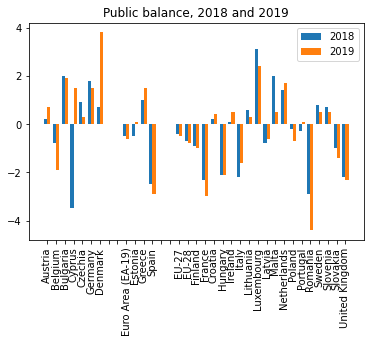

In [34]:
#%matplotlib inline
#args = requestLib.args_to_dict('table= gov_10dd_edpt1', 'na_item=B9', 'precision=1', 'unit=PC_GDP', 'time=2018,2019','sector=S13')
args = requestLib.args_to_dict_fun(table='gov_10dd_edpt1', na_item='B9', unit = 'PC_GDP', time='2018,2019', sector='S13')
r = response_fun(client,  clean_dict=clean_country, remove_list=noCountry,args=args, void_item=True)

fig, ax = plt.subplots()
plt.title("Public balance, 2018 and 2019")
pos = np.arange(len(r.x_labels))
ax.set_xticks(pos)
ax.set_xticklabels(r.x_labels, rotation = 90)
width = 0.35

ax.bar(pos -  width/2., list(r.values['2018'].values()),  width, label='2018')
ax.bar(pos +  width/2., list(r.values['2019'].values()),  width, label='2019')
plt.legend(loc='upper right')

plt.show()


# Public Balance and General Governement Debt, 2016-2019

In [35]:
r = response_fun(client,  clean_dict=clean_country, remove_list=noCountry,args=args, void_item=True)
debt = r.DF
debt

[+] OK! Data recieved
	Succesful response


,2018,2019
Austria,0.2,0.7
Belgium,-0.8,-1.9
Bulgaria,2.0,1.9
Cyprus,-3.5,1.5
Czechia,0.9,0.3
Germany,1.8,1.5
Denmark,0.7,3.8
Euro area - 17 countries (2011-2013),0.0,0.0
Euro area - 18 countries (2014),0.0,0.0
Euro Area (EA-19),-0.5,-0.6


## General government debt, 2019 and 2018

Arguments for the GET request:

* **sector** = S13 - general government
* **na_item** = GD - conslidated gross
* **time** = 2018,2019 - 2018 & 2019
* **unit** = PC_GDP - percentage of GDP

Arguments to **response_fun** and plot filters:
* **clean_dict**: clean_country
* **remove_list**: noCountry
* **void_item**: True - void labels for non shown countries

[+] OK! Data recieved
	Succesful response


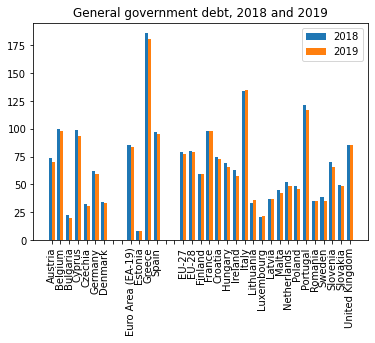

In [36]:
#args = requestLib.args_to_dict('table= gov_10dd_edpt1', 
#                    'na_item=GD', 
#                    'precision=1', 
#                    'unit=PC_GDP', 
#                    'time=2018,2019',
#                    'sector=S13')
args = client.update_args('na_item=GD')
r = response_fun(client,  clean_dict=clean_country, remove_list=noCountry, void_item=True, args=args)

pos = np.arange(len(r.x_labels))

fig, ax = plt.subplots()
plt.title("General government debt, 2018 and 2019")
ax.set_xticks(pos)
ax.set_xticklabels(r.x_labels, rotation = 90)
width = 0.35

ax.bar(pos -  width/2., list(r.values['2018'].values()),  width, label='2018')
ax.bar(pos +  width/2., list(r.values['2019'].values()),  width, label='2019')
plt.legend(loc='upper right')

plt.show()

## Government revenu and expenditure 2009 - 2019 

### Development of total expenditure and total revenue 2009-2019 (% of GDP)

#### Arguments for the GET request:

First request
* **sector** = S13 - general government
* **na_item** = TE - total expenditure
* **time** = 2009,2010,2011,2012,2013,2014,2015,2016,2017,1018,2019 - from 2009 to 2019
* **unit** = PC_GDP - percentage of GDP

Second request
* **sector** = S13 - general government
* **na_item** = TR - total ereveues
* **time** = 2009,2010,2011,2012,2013,2014,2015,2016,2017,1018,2019 - from 2009 to 2019
* **unit** = PC_GDP - percentage of GDP

#### Arguments to **response_fun** and filter countries:
* **clean_dict**: clean_country (defined above)
* Only the countries **EU-27** and **Euro Area (EA-19)**

[+] OK! Data recieved
	Succesful response
[+] OK! Data recieved
	Succesful response


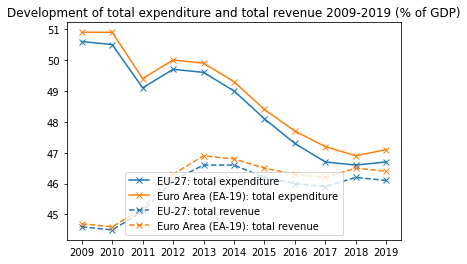

In [37]:
y = {'total expenditure': {'EU-27':[],'Euro Area (EA-19)' :[] }, 
     'total revenue': {'EU-27':[],'Euro Area (EA-19)' :[] }
     }
#args = requestLib.args_to_dict('table=gov_10a_main', 
#                    'na_item=TE', 
#                    'precision=1', 
#                    'unit=PC_GDP', 
#                    'time= 2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019',
#                    'sector=S13')

args = requestLib.args_to_dict_fun(table = 'gov_10a_main',
                                   na_item = 'TE',
                                   unit = 'PC_GDP',
                                   time = '2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019',
                                sector = 'S13')
expenditures = response_fun(client,  clean_dict=clean_country,args=args)
for country in y['total expenditure']:
    for year in expenditures.values:
        y['total expenditure'][country].append(expenditures.values[year][country])

args = client.update_args('na_item=TR')
revenues = response_fun(client,  clean_dict=clean_country, args = args)

for country in y['total revenue']:
    for year in revenues.values:
        y['total revenue'][country].append(revenues.values[year][country])

##### PLOT
plot_colors = ['C0', 'C1']
plt.title("Development of total expenditure and total revenue 2009-2019 (% of GDP)")
x = list(revenues.values.keys())
for measure in y:
    i = 0
    for country in y[measure]:
        if measure == 'total revenue':
            line_style = '--'
        else:
            line_style = '-'   
        plt.plot(x,y[measure][country],ls=line_style, marker='x', label='%s: %s' % (country, measure), color=plot_colors[i])
        i += 1
plt.legend(loc='lower center')
plt.show()

### Development of total expenditure and total revenue 2009-2019 (Billion EUR)

#### Arguments for the GET request:

First request
* **sector** = S13 - general government
* **na_item** = TE - total expenditure
* **time** = 2009,2010,2011,2012,2013,2014,2015,2016,2017,1018,2019 - from 2009 to 2019
* **unit** = MIO_EUR - billion EUR

Second request
* **sector** = S13 - general government
* **na_item** = TR - total ereveues
* **time** = 2009,2010,2011,2012,2013,2014,2015,2016,2017,1018,2019 - from 2009 to 2019
* **unit** = MIO_EUR - billion EUR

#### Arguments to **response_fun** and filter countries:
* **clean_dict**: clean_country (defined above)
* Only the countries **EU-27** and **Euro Area (EA-19)**

[+] OK! Data recieved
	Succesful response
[+] OK! Data recieved
	Succesful response


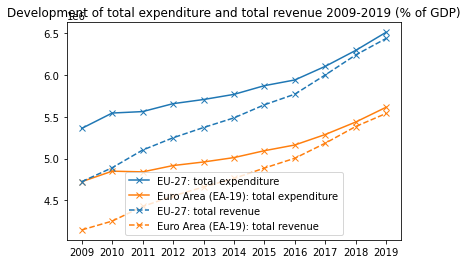

In [38]:
y = {'total expenditure': {'EU-27':[],'Euro Area (EA-19)' :[] }, 
     'total revenue': {'EU-27':[],'Euro Area (EA-19)' :[] }
     }

args = requestLib.args_to_dict('table=gov_10a_main', 
                    'na_item=TE', 
                    'precision=1', 
                    'unit=MIO_EUR', 
                    'time= 2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019',
                    'sector=S13')

#client.update_args('na_item=TE', 'unit=MIO_EUR')
#response = client.get_request(args)
#frame = assign_reference(response.data['dict'])
#countries = frame['lines']
#times = frame['columns']
#expendures = dataDealer.check_data_by_status(response.data['dict'])

#expenditures,  countries = dataDealer.json_to_data(lines=countries, 
                                        # columns=times, 
                                        # values=expendures,
                                        # clean_dict=clean_country)
expenditures = response_fun(client,  clean_dict=clean_country, args = args)

for country in y['total expenditure']:
    for year in expenditures.values:
        y['total expenditure'][country].append(expenditures.values[year][country])
        
args = client.update_args('na_item=TR')
revenues = response_fun(client,  clean_dict=clean_country, args = args)

for country in y['total revenue']:
    for year in revenues.values:
        y['total revenue'][country].append(revenues.values[year][country])

##### PLOT
plot_colors = ['C0', 'C1']
plt.title("Development of total expenditure and total revenue 2009-2019 (% of GDP)")
x = list(revenues.values.keys())
for measure in y:
    i = 0
    for country in y[measure]:
        if measure == 'total revenue':
            line_style = '--'
        else:
            line_style = '-'   
        plt.plot(x,y[measure][country],ls=line_style, marker='x', label='%s: %s' % (country, measure), color=plot_colors[i])
        i += 1
plt.legend(loc='lower center')
plt.show()

### Governement revenue and expenditure, 2019

Arguments for the GET request:
* **sector**: S13 - general goverment
* **na_item**: TE,TR - total expenditures & total revenues
* **time**: 2019

Arguments to **response_fun** and plot filters
* **remove_list**: noCountry (defined above)
* **clean_dict**: clean_countries (defined above)
* **void_item**: True - void labels for not shown countries
* **multiciplity**: na_item

[+] OK! Data recieved
	Succesful response
34
2


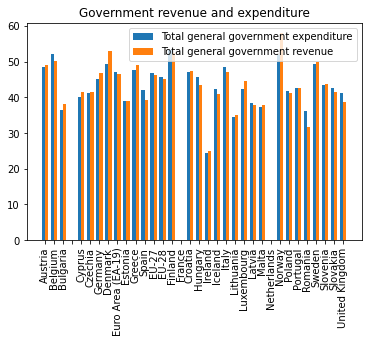

In [40]:
args = requestLib.args_to_dict('table=gov_10a_main', 
                    'na_item=TE,TR', 
                    'precision=1', 
                    'unit=PC_GDP', 
                    'time= 2019',
                    'sector=S13')

response = client.get_request(args)

values = dataDealer.check_data_by_status(response.data['dict'], toZero=True)

frame = assign_reference(response.data['dict'], multiplicity='na_item')
countries = frame['lines']
na_items = frame['columns']
print(len(countries))
print(len(na_items))
values, countries = dataDealer.json_to_data(lines=countries, 
                                            columns=na_items, 
                                            values=values,
                                            remove_list=noCountry, 
                                            void_item=True, 
                                            clean_dict=clean_country,
                                            multiple_key='na_item')

plot_x_labels = dataDealer.clean_label(lines=countries, remove_list=noCountry)

#r = response_fun(client,  clean_dict=clean_country, remove_list=noCountry,void_item=True,multiplicity='na_item' ,args = args)

pos = np.arange(len(plot_x_labels))

fig, ax = plt.subplots()
plt.title("Government revenue and expenditure")
ax.set_xticks(pos)
ax.set_xticklabels(plot_x_labels, rotation = 90)
width = 0.35
a = pos - width/2.

ax.bar(pos - width/2., list(values['Total general government expenditure'].values()),  width, label='Total general government expenditure')
ax.bar(pos +  width/2., list(values['Total general government revenue'].values()),  width, label='Total general government revenue')
plt.legend(loc='upper right')

plt.show()

### Composition of tota revenue, 2019

In [ ]:
revenu = temp_array
z = {}
client.update_args('na_item=D2REC,D5REC,D91REC')
response = client.get_request()
values = dataDealer.check_data_by_status(response.data['dict'], toZero=True)
frame = assign_reference(response.data['dict'], multiplicity='na_item')
countries = frame['lines']
na_items = frame['columns']

taxes, countries = dataDealer.json_to_data(lines=countries, 
                                            columns=na_items,
                                            remove_list=noCountry,
                                            values=values, 
                                            void_item=True, 
                                            clean_dict=clean_country,
                                            multiple_key='na_item')


plot_x_labels = dataDealer.clean_label(lines=countries, remove_list=noCountry)
z['taxes'] = taxes


tot_taxes = {}
for item in countries:
    tot_taxes[item] = []
flag = False
for key in taxes:
    for country in taxes[key]:
        tot_taxes[country].append(taxes[key][country])

revenu_key = 'Total general government revenue'

taxes = {}
for key in tot_taxes:
    if revenu[revenu_key][key] != 0:
        taxes[key] = sum(tot_taxes[key]) / revenu[revenu_key][key] * 100
    else:
        taxes[key] = 0

y = {}
y['taxes'] = taxes

client.update_args('na_item=D61REC')
response = client.get_request()

data = dataDealer.check_data_by_status(response.data['dict'], toZero=True)
frame = assign_reference(response.data['dict'], multiplicity='na_item')
countries = frame['lines']
na_items = frame['columns']
social_contributions, countries = dataDealer.json_to_data(lines=countries, 
                                            columns=na_items,
                                            remove_list=noCountry,
                                            values=data, 
                                            void_item=True, 
                                            clean_dict=clean_country,
                                            multiple_key='na_item')

z['social contributions'] = social_contributions
kkey = 'Net social contrinutions'
api_key = list(social_contributions.keys())[0] 
y[kkey] = {}
for key in social_contributions[api_key]:
    if revenu[revenu_key][key] != 0:
        y[kkey][key] = social_contributions[api_key][key] / revenu[revenu_key][key] * 100  

client.update_args('na_item=P11_P12_P131')
response = client.get_request()

data = dataDealer.check_data_by_status(response.data['dict'], toZero=True)
frame = assign_reference(response.data['dict'], multiplicity='na_item')
countries = frame['lines']
na_items = frame['columns']
sales, countries = dataDealer.json_to_data(lines=countries, 
                                            columns=na_items,
                                            remove_list=noCountry,
                                            values=data, 
                                            void_item=True, 
                                            clean_dict=clean_country,
                                            multiple_key='na_item')

z['sales'] = sales
kkey = 'Market output, output for own final use and payments for non-market output'
y[kkey] = {}
for key in sales[kkey]:
    if revenu[revenu_key][key] != 0:
        y[kkey][key] = sales[kkey][key] / revenu[revenu_key][key] * 100  

client.update_args('na_item=D92REC,D99REC')
response = client.get_request()
data = dataDealer.check_data_by_status(response.data['dict'], toZero=True)
frame = assign_reference(response.data['dict'], multiplicity='na_item')
countries = frame['lines']
na_items = frame['columns']
proprety_income, countries = dataDealer.json_to_data(lines=countries, 
                                            columns=na_items,
                                            remove_list=noCountry,
                                            values=data, 
                                            void_item=True, 
                                            clean_dict=clean_country,
                                            multiple_key='na_item')
z['proprety_income'] = proprety_income
tot_income = {}
for item in countries:
    tot_income[item] = []
for key in proprety_income:
    for country in proprety_income[key]:
        tot_income[country].append(proprety_income[key][country])
        
income = {}
for key in tot_income:
    if revenu[revenu_key][key] != 0:
        income[key] = sum(tot_income[key]) / revenu[revenu_key][key] * 100
    else:
        income[key] = 0
y['Proprety income'] = income


client.update_args('na_item=D39REC,D4REC,D7REC')
response = client.get_request()

data = dataDealer.check_data_by_status(response.data['dict'], toZero=True)
frame = assign_reference(response.data['dict'], multiplicity='na_item')
countries = frame['lines']
na_items = frame['columns']
other, countries = dataDealer.json_to_data(lines=countries, 
                                            columns=na_items,
                                            remove_list=noCountry,
                                            values=data, 
                                            void_item=True, 
                                            clean_dict=clean_country,
                                            multiple_key='na_item')
z['other'] = other
print(len(other['Other subsidies on production, receivable']))
tot_other = {}
for item in countries:
    tot_other[item] = []
for key in other:
    for country in other[key]:
        tot_other[country].append(other[key][country])
        
tmp = {}
for key in tot_other:
    if revenu[revenu_key][key] != 0:
        tmp[key] = sum(tot_other[key]) / revenu[revenu_key][key] * 100
    else:
        tmp[key] = 0
y['other'] = tmp


                    
            
plot_x_labels = dataDealer.clean_label(lines=countries, remove_list=noCountry)

pos = np.arange(len(plot_x_labels))
fig, ax = plt.subplots()
plt.title("Main components of government revenu, 2019")
ax.set_xticks(pos)
ax.set_xticklabels(plot_x_labels, rotation = 90)
width = 0.35

ax.bar(pos, list(y['other'].values()),  width, label='Total general government expenditure')
#ax.bar(pos-width, list(y['other'].values()),  width, label='Total general government revenue')
plt.legend(loc='upper right')

plt.show()

###############################################################################
##### The database seems not to contain the values for all the countries plottet in the article:
##### Not all na_items refear to all the countries we are looking to plot
###########################################
print('The database seems not to contain the values for all the countries plottet in the article:')
print('not all na_items refear to all the countries we want to plot\n')
print('\tlen(proprety_income) = %d' % len(y['Proprety income']) )
print('\tlen(other) = %d' % len(y['other']))

In [ ]:
###############################################################################
##### The database seems not to contain the values for all the countries plottet in the article:
##### Not all na_items refear to all the countries we are looking to plot
###########################################
print('The database seems not to contain the values for all the countries plottet in the article:')
print('not all na_items refear to all the countries we want to plot\n')
print('\tlen(proprety_income) = %d' % len(y['Proprety income']) )
print('\tlen(other) = %d' % len(y['other']))
print('\nSee error below')
try:
    h =  prepare_for_plot(z, revenu, countries)
except Exception as e:
    print('\n\t---> h =  prepare_for_plot(z, revenu, countries)')
    print('\tLine 11: -----> if tot[key] == != 0.\n')
    print('\tKeyError: %s'% str(e))

### Restore import settings

In [ ]:
# lanch as last commend to restore the previous python import settings
for location in costum_lib_locations:
    try:
        sys.path.remove(location)
    except ValueError:
        print("path already removed")